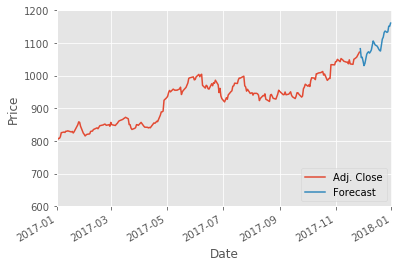

In [6]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import pickle

style.use('ggplot')

#Create & adjust dataframe
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]


#Define forecast column, fill NaNs, shift label column
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

#Let X be the feature array
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X) #Preprocess feature data
X_lately = X[-forecast_out:] 
X = X[:-forecast_out]

df.dropna(inplace=True) #Drop NaNs from dataframe

y = np.array(df['label'])

#Train & test the classifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('Confidence', confidence)
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

#Predict and cleanup forecast data
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

#Assign forecast dates
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


#This loop adds the forecast set to the dataframe 
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

#Graphing
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlim('2017','2018')
plt.ylim(600,1200)
plt.show()

In [27]:
from statistics import mean

xs = np.array([1,2,3,4,5], dtype=np.float64)
ys = np.array([5,4,6,5,6], dtype=np.float64)

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)**2) - mean(xs**2)))
    b = mean(ys) - m*mean(xs)
    return m,b

m,b = best_fit_slope_and_intercept(xs,ys)

print(m,b)

0.3 4.3


In [28]:
regression_line = [(m*x)+b for x in xs]
print(regression_line)

[4.6000000000000023, 4.9000000000000012, 5.2000000000000002, 5.4999999999999991, 5.799999999999998]


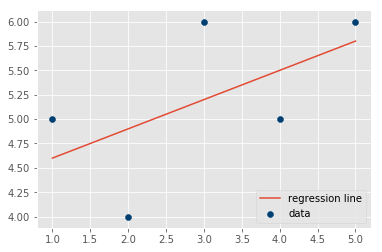

In [29]:
plt.scatter(xs,ys,color='#003F72', label='data')
plt.plot(xs, regression_line, label='regression line')
plt.legend(loc=4)
plt.show()

In [30]:
predict_x = 7
predict_y = (m*predict_x)+b
print(predict_y)

6.4


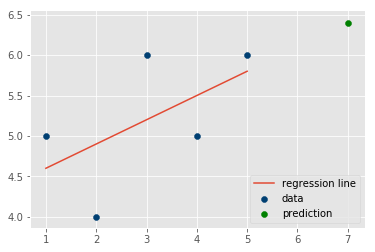

In [31]:
plt.scatter(xs,ys,color='#003F72',label='data')
plt.scatter(predict_x,predict_y,color='g',label='prediction')
plt.plot(xs, regression_line, label='regression line')
plt.legend(loc=4)
plt.show()

In [32]:
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)
    
m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]

r_squared = coefficient_of_determination(ys,regression_line)
print(r_squared)


0.321428571429


SE_r:  1289.97382739
SE_m:  20521.775
r squared:  0.937141215738


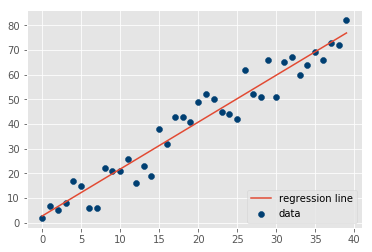

In [37]:
import random

def create_dataset(hm,variance,step=2,correlation=False):
    val = 1
    ys = []
    for i in range(hm):
        y = val + random.randrange(-variance,variance)
        ys.append(y)
        if correlation and correlation == 'pos':
            val+=step
        elif correlation and correlation == 'neg':
            val-=step

    xs = [i for i in range(len(ys))]
    
    return np.array(xs, dtype=np.float64),np.array(ys,dtype=np.float64)

def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)

    return m, b


def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [mean(ys_orig) for y in ys_orig]

    squared_error_regr = sum((ys_line - ys_orig) * (ys_line - ys_orig))
    squared_error_y_mean = sum((y_mean_line - ys_orig) * (y_mean_line - ys_orig))

    print('SE_r: ',squared_error_regr)
    print('SE_m: ',squared_error_y_mean)

    r_squared = 1 - (squared_error_regr/squared_error_y_mean)

    return r_squared


xs, ys = create_dataset(40,10,2,correlation='pos')
m, b = best_fit_slope_and_intercept(xs,ys)
regression_line = [(m*x)+b for x in xs]
r_squared = coefficient_of_determination(ys,regression_line)
print('r squared: ',r_squared)

plt.scatter(xs,ys,color='#003F72', label = 'data')
plt.plot(xs, regression_line, label = 'regression line')
plt.legend(loc=4)
plt.show()